In [ ]:
import os
import json
import shutil

old_folder = '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/0328'
new_folder = '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328'

image_folder = os.path.join(new_folder, 'images')
label_folder = os.path.join(new_folder, 'labels')
error_folder = os.path.join(new_folder, 'error_json')

os.makedirs(image_folder, exist_ok=True)
os.makedirs(label_folder, exist_ok=True)
os.makedirs(error_folder, exist_ok=True)

def convert_to_yolo_format(data, image_w, image_h):
    x_min, y_min = data['points'][0]
    x_max, y_max = data['points'][1]

    x_center = ((x_min + x_max) / 2) / image_w
    y_center = ((y_min + y_max) / 2) / image_h
    width = abs(x_max - x_min) / image_w
    height = abs(y_max - y_min) / image_h

    return x_center, y_center, width, height

def process_file(filename):
    json_path = os.path.join(old_folder, filename)

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Lấy tên ảnh chuẩn
        image_name = os.path.basename(data['imagePath'].replace('\\', '/'))
        image_path = os.path.join(old_folder, image_name)

        if not os.path.exists(image_path):
            print(f"[ERROR] Không tìm thấy ảnh: {image_name}")
            shutil.copy(json_path, os.path.join(error_folder, filename))
            return

        image_w, image_h = data['imageWidth'], data['imageHeight']
        label_path = os.path.join(label_folder, os.path.splitext(image_name)[0] + '.txt')

        shutil.copy(image_path, os.path.join(image_folder, image_name))

        with open(label_path, 'w', encoding='utf-8') as txt_file:
            for shape in data['shapes']:
                class_id = int(shape.get('label', 0))

                x_center, y_center, width, height = convert_to_yolo_format(shape, image_w, image_h)
                txt_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    except Exception as e:
        print(f"[ERROR] Lỗi xử lý {filename} : {e}")
        shutil.copy(json_path, os.path.join(error_folder, filename))

for filename in os.listdir(old_folder):
    if filename.endswith('.json'):
        process_file(filename)

print("✅ Hoàn tất tách folder và chuyển label chuẩn YOLO!")


✅ Hoàn tất tách folder và chuyển label chuẩn YOLO!


In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# ============================================
# Load ground truth label data
# ============================================
def load_labels(gt_file_path):
    data = []
    with open(gt_file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                img_path, label = line.split('\t')
                data.append({'img_path': img_path, 'label': label})
    df = pd.DataFrame(data)
    return df

# ============================================
# Display dataset overview
# ============================================
def data_overview(df):
    print("Dataset Information:")
    print(df.info())
    print("\nSample Records:")
    print(df.sample(5))
    print("\nNumber of Unique Labels:", df['label'].nunique())
    print("Total Samples:", len(df))

# ============================================
# Plot label length distribution
# ============================================
def label_length_distribution(df):
    df['label_length'] = df['label'].apply(len)

    plt.figure(figsize=(10, 6))
    sns.histplot(df['label_length'], bins=range(1, df['label_length'].max() + 2), kde=False)
    plt.title('Label Length Distribution')
    plt.xlabel('Label Length')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

# ============================================
# Character frequency analysis and display special characters
# ============================================
def char_frequency(df):
    all_text = ''.join(df['label'].tolist())
    char_counts = Counter(all_text)

    # Convert counter to DataFrame for visualization
    char_df = pd.DataFrame(char_counts.items(), columns=['Character', 'Frequency']).sort_values(by='Frequency', ascending=False)

    # Print special characters found
    print("Characters found in the dataset:")
    for char, freq in char_counts.items():
        if not char.isalnum():
            print(f"  Special character: '{char}'  |  Frequency: {freq}")

    # Plot character frequency
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Character', y='Frequency', data=char_df)
    plt.title('Character Frequency in License Plate Labels')
    plt.xlabel('Character')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    return char_df

# ============================================
# Display sample images with their labels
# ============================================
def show_sample_images(df, image_folder, sample_size=5):
    sample_df = df.sample(sample_size)

    plt.figure(figsize=(15, 5))
    for idx, row in enumerate(sample_df.itertuples(), 1):
        img_path = os.path.join(image_folder, row.img_path)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, sample_size, idx)
            plt.imshow(img)
            plt.title(f"Label: {row.label}")
            plt.axis('off')
        else:
            print(f"Image not found: {img_path}")
    plt.show()

# ============================================
# Check data issues: missing images and empty labels
# ============================================
def check_data_issues(df, image_folder):
    missing_imgs = []
    empty_labels = df[df['label'].str.strip() == '']

    for row in df.itertuples():
        img_path = os.path.join(image_folder, row.img_path)
        if not os.path.exists(img_path):
            missing_imgs.append(img_path)

    print(f"Missing images: {len(missing_imgs)}")
    print(f"Empty labels: {len(empty_labels)}")

    if missing_imgs:
        print("\nFirst 5 missing image paths:")
        print(missing_imgs[:5])

    return missing_imgs, empty_labels

# ============================================
# Clean label text: remove spaces and convert to uppercase
# ============================================
def clean_label(label):
    cleaned = label.strip().upper()
    cleaned = cleaned.replace(" ", "")
    return cleaned

# ============================================
# Validate label format based on Vietnam license plate rules
# ============================================
def is_valid_plate(label):
    # Example pattern: two digits, a letter, an optional hyphen, numbers, optional dot and more numbers
    pattern = r'^\d{2}[A-Z]-?\d{1,4}(\.\d{2,3})?$'
    return bool(re.match(pattern, label))

# ============================================
# Validate all labels and display invalid labels
# ============================================
def validate_labels(df):
    df['cleaned_label'] = df['label'].apply(clean_label)
    df['valid'] = df['cleaned_label'].apply(is_valid_plate)

    invalid_labels = df[df['valid'] == False]

    print(f"Invalid labels count: {len(invalid_labels)}")
    if len(invalid_labels) > 0:
        print("\nFirst 10 invalid labels:")
        display(invalid_labels[['label', 'cleaned_label']].head(10))

    return invalid_labels

# ============================================
# Print labels that contain specific special characters
# ============================================
def print_labels_by_special_char(df, special_chars=None):
    if special_chars is None:
        special_chars = ['-', '.', '·', ':', '\\', '_']

    print("Labels containing special characters:\n")

    for char in special_chars:
        escaped_char = re.escape(char)
        labels_with_char = df[df['label'].str.contains(escaped_char, regex=True)]

        print(f"Special character: '{char}'  |  Labels count: {len(labels_with_char)}")
        print(labels_with_char['label'].tolist()[:10])  # Print first 10 labels for each character
        print("-" * 60)

# ============================================
# Run the complete EDA process
# ============================================
def run_full_eda(gt_file_path, image_folder, sample_image_count=5):
    print("Starting dataset analysis...")

    df = load_labels(gt_file_path)

    data_overview(df)

    label_length_distribution(df)

    char_df = char_frequency(df)

    show_sample_images(df, image_folder, sample_image_count)

    check_data_issues(df, image_folder)

    validate_labels(df)

    print_labels_by_special_char(df)

    print("EDA process completed.")

    return df, char_df


Starting dataset analysis...
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  3204 non-null   object
 1   label     3204 non-null   object
dtypes: object(2)
memory usage: 50.2+ KB
None

Sample Records:
                   img_path  label
841      HR274_images_0.jpg  59-P2
932      HR527_images_1.jpg   5167
3052  crop_plate_1348_1.jpg  77-Y1
1329       HR6_images_0.jpg  59-F1
2235     HR604_images_1.jpg   7967

Number of Unique Labels: 1903
Total Samples: 3204


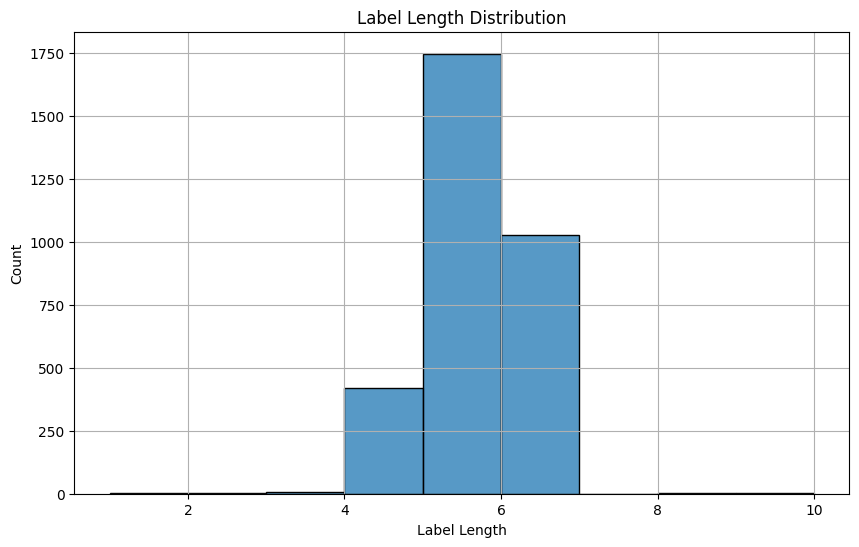

Characters found in the dataset:
  Special character: '-'  |  Frequency: 1568
  Special character: '.'  |  Frequency: 1038
  Special character: '·'  |  Frequency: 6
  Special character: ':'  |  Frequency: 6
  Special character: '\'  |  Frequency: 2
  Special character: '_'  |  Frequency: 1


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


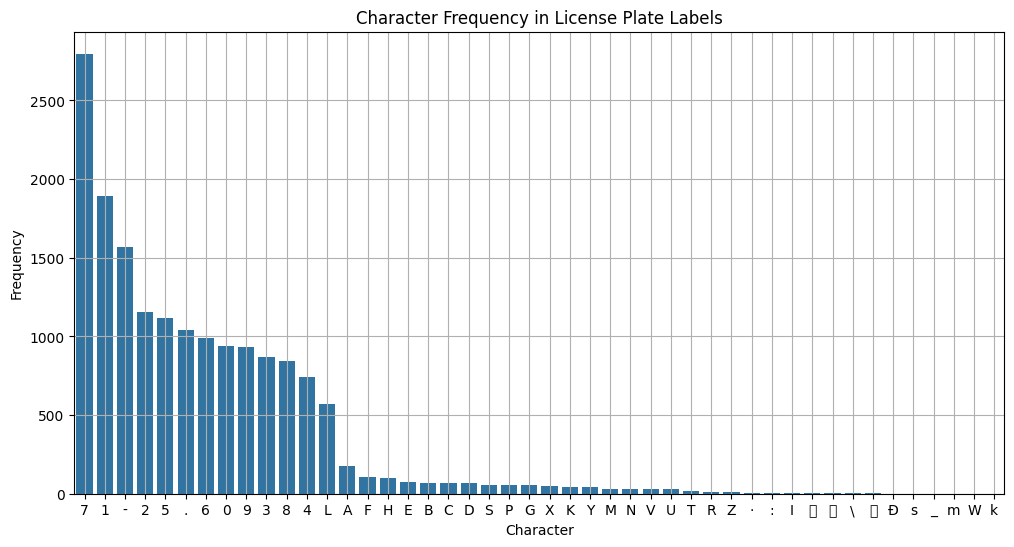

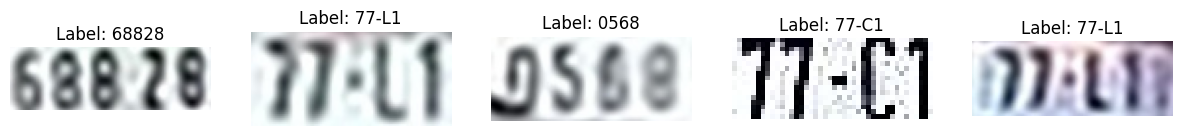

Missing images: 0
Empty labels: 0
Invalid labels count: 3197

First 10 invalid labels:


,label,cleaned_label
0,72-F1,72-F1
1,20741,20741
2,77-L1,77-L1
3,833.35,833.35
4,050.69,050.69
5,77-G1,77-G1
6,77-L1,77-L1
7,056.03,056.03
8,65-X3,65-X3
9,1313,1313


Labels containing special characters:

Special character: '-'  |  Labels count: 1568
['72-F1', '77-L1', '77-G1', '77-L1', '65-X3', '59-L1', '51-Z3', '77-L1', '77-L1', '52-H9']
------------------------------------------------------------
Special character: '.'  |  Labels count: 1038
['833.35', '050.69', '056.03', '540.63', '778.35', '597.53', '656.57', '463.12', '661.56', '040.79']
------------------------------------------------------------
Special character: '·'  |  Labels count: 6
['64·H2', '51·L3', '65·R1', '00·C1', '59·E1', '71·B1']
------------------------------------------------------------
Special character: ':'  |  Labels count: 6
['81:83', '77:B1', '59:F1', '77:D1', '59:N1', '77:L2']
------------------------------------------------------------
Special character: '\'  |  Labels count: 1
['81-F5\\\\1']
------------------------------------------------------------
Special character: '_'  |  Labels count: 1
['81_H1']
------------------------------------------------------------
EDA 

In [ ]:
# Đường dẫn dữ liệu
gt_file_path = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/rec_gt_train_new.txt'
image_folder = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/train_set'

# Thực thi EDA chi tiết
df_ocr, char_df = run_full_eda(gt_file_path, image_folder, sample_image_count=5)


In [ ]:
def print_labels_by_special_char(df, special_chars=None):
    if special_chars is None:
        # Danh sách ký tự đặc biệt bạn đã liệt kê
        special_chars = ['-', '.', '·', ':', '\\', '_']

    print("🔎 In ra các label chứa ký tự đặc biệt và số lượng tương ứng:\n")

    for char in special_chars:
        # Escape ký tự đặc biệt nếu cần cho regex
        escaped_char = re.escape(char)

        # Lọc những label có chứa ký tự đó
        labels_with_char = df[df['label'].str.contains(escaped_char, regex=True)]

        # In kết quả
        print(f"➡️ Ký tự đặc biệt: '{char}'  |  Số lượng label chứa ký tự này: {len(labels_with_char)}")
        print(labels_with_char['label'].tolist()[:10])  # In ra 10 label đầu tiên cho dễ xem
        print("-" * 60)  # Ngăn cách cho dễ nhìn

    print("✅ Đã in xong tất cả các nhóm ký tự đặc biệt.")


In [ ]:
# Gọi hàm để in từng nhóm label có ký tự đặc biệt
print_labels_by_special_char(df_ocr)



🔎 In ra các label chứa ký tự đặc biệt và số lượng tương ứng:

➡️ Ký tự đặc biệt: '-'  |  Số lượng label chứa ký tự này: 1568
['72-F1', '77-L1', '77-G1', '77-L1', '65-X3', '59-L1', '51-Z3', '77-L1', '77-L1', '52-H9']
------------------------------------------------------------
➡️ Ký tự đặc biệt: '.'  |  Số lượng label chứa ký tự này: 1038
['833.35', '050.69', '056.03', '540.63', '778.35', '597.53', '656.57', '463.12', '661.56', '040.79']
------------------------------------------------------------
➡️ Ký tự đặc biệt: '·'  |  Số lượng label chứa ký tự này: 6
['64·H2', '51·L3', '65·R1', '00·C1', '59·E1', '71·B1']
------------------------------------------------------------
➡️ Ký tự đặc biệt: ':'  |  Số lượng label chứa ký tự này: 6
['81:83', '77:B1', '59:F1', '77:D1', '59:N1', '77:L2']
------------------------------------------------------------
➡️ Ký tự đặc biệt: '\'  |  Số lượng label chứa ký tự này: 1
['81-F5\\\\1']
------------------------------------------------------------
➡️ Ký tự đ

In [ ]:
def unique_char_count_per_label(df):
    df['unique_char_count'] = df['label'].apply(lambda x: len(set(x)))

    plt.figure(figsize=(10, 6))
    sns.histplot(df['unique_char_count'], bins=range(1, df['unique_char_count'].max() + 2), kde=False)
    plt.title('Unique Character Count per Label')
    plt.xlabel('Number of Unique Characters')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    return df[['label', 'unique_char_count']]
def special_char_ratio(df, special_chars=None):
    if special_chars is None:
        special_chars = ['-', '.', '·', ':', '\\', '_']

    def calc_ratio(label):
        total_chars = len(label)
        special_count = sum([label.count(char) for char in special_chars])
        return special_count / total_chars if total_chars > 0 else 0

    df['special_char_ratio'] = df['label'].apply(calc_ratio)

    plt.figure(figsize=(10, 6))
    sns.histplot(df['special_char_ratio'], bins=20, kde=False)
    plt.title('Special Character Ratio in Labels')
    plt.xlabel('Ratio of Special Characters')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    return df[['label', 'special_char_ratio']]
def province_code_distribution(df):
    # Province code là 2 số đầu tiên của label
    df['province_code'] = df['label'].str.extract(r'^(\d{2})')

    province_count = df['province_code'].value_counts().sort_index()

    plt.figure(figsize=(14, 6))
    sns.barplot(x=province_count.index, y=province_count.values)
    plt.title('License Plate Count by Province Code')
    plt.xlabel('Province Code')
    plt.ylabel('Number of License Plates')
    plt.grid(True)
    plt.show()

    return df[['label', 'province_code']]
def image_resolution_analysis(df, image_folder):
    widths = []
    heights = []
    aspect_ratios = []

    for row in df.itertuples():
        img_path = os.path.join(image_folder, row.img_path)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h if h != 0 else 0)

    # Tổng hợp kết quả
    resolution_df = pd.DataFrame({
        'width': widths,
        'height': heights,
        'aspect_ratio': aspect_ratios
    })

    # Plot width/height distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(resolution_df['width'], bins=20)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')

    plt.subplot(1, 2, 2)
    sns.histplot(resolution_df['height'], bins=20)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.show()

    # Plot aspect ratio distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(resolution_df['aspect_ratio'], bins=20)
    plt.title('Aspect Ratio Distribution (Width / Height)')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    return resolution_df
def duplicate_label_analysis(df):
    duplicated_labels = df[df.duplicated('label', keep=False)].sort_values(by='label')

    print(f"Total duplicated labels: {len(duplicated_labels)}")

    if len(duplicated_labels) > 0:
        display(duplicated_labels.head(10))

    return duplicated_labels


In [ ]:
def run_advanced_eda(gt_file_path, image_folder):
    print("Starting advanced EDA...")

    df = load_labels(gt_file_path)

    # Base EDA
    data_overview(df)
    label_length_distribution(df)
    char_df = char_frequency(df)
    check_data_issues(df, image_folder)
    validate_labels(df)
    show_sample_images(df, image_folder, sample_size=5)

    # Advanced EDA
    unique_char_count_per_label(df)
    special_char_ratio(df)
    province_code_distribution(df)
    resolution_df = image_resolution_analysis(df, image_folder)
    duplicate_labels = duplicate_label_analysis(df)

    print("Advanced EDA completed!")

    return df, char_df, resolution_df, duplicate_labels


Starting advanced EDA...
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  3204 non-null   object
 1   label     3204 non-null   object
dtypes: object(2)
memory usage: 50.2+ KB
None

Sample Records:
                   img_path  label
2252   crop_plate_415_0.jpg  77-L1
633    crop_plate_736_0.jpg  77-L1
2038   crop_plate_141_0.jpg  77-L1
378   crop_plate_1440_1.jpg  77-L1
929      HR211_images_0.jpg  59-M1

Number of Unique Labels: 1903
Total Samples: 3204


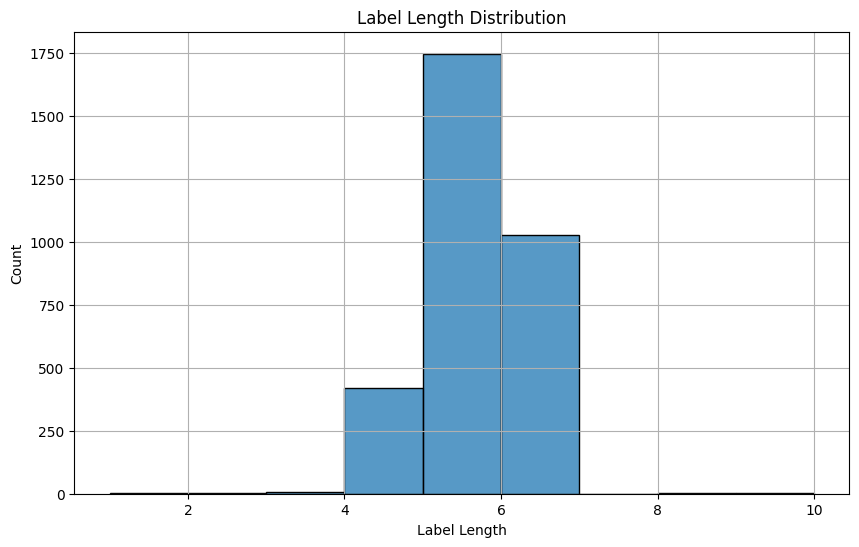

Characters found in the dataset:
  Special character: '-'  |  Frequency: 1568
  Special character: '.'  |  Frequency: 1038
  Special character: '·'  |  Frequency: 6
  Special character: ':'  |  Frequency: 6
  Special character: '\'  |  Frequency: 2
  Special character: '_'  |  Frequency: 1


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


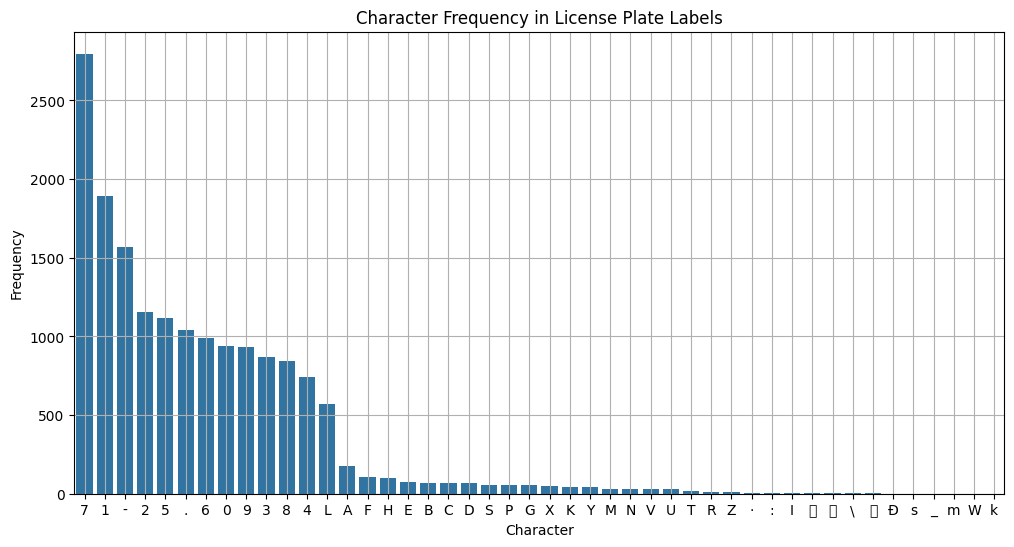

Missing images: 0
Empty labels: 0
Invalid labels count: 3197

First 10 invalid labels:


,label,cleaned_label
0,72-F1,72-F1
1,20741,20741
2,77-L1,77-L1
3,833.35,833.35
4,050.69,050.69
5,77-G1,77-G1
6,77-L1,77-L1
7,056.03,056.03
8,65-X3,65-X3
9,1313,1313


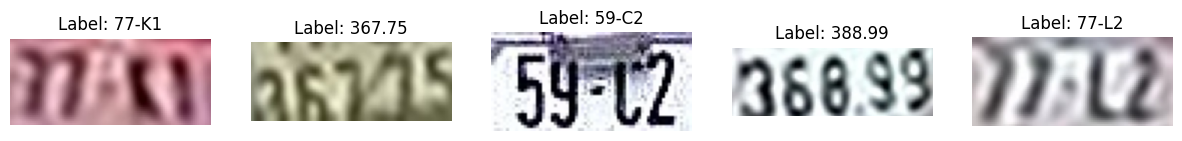

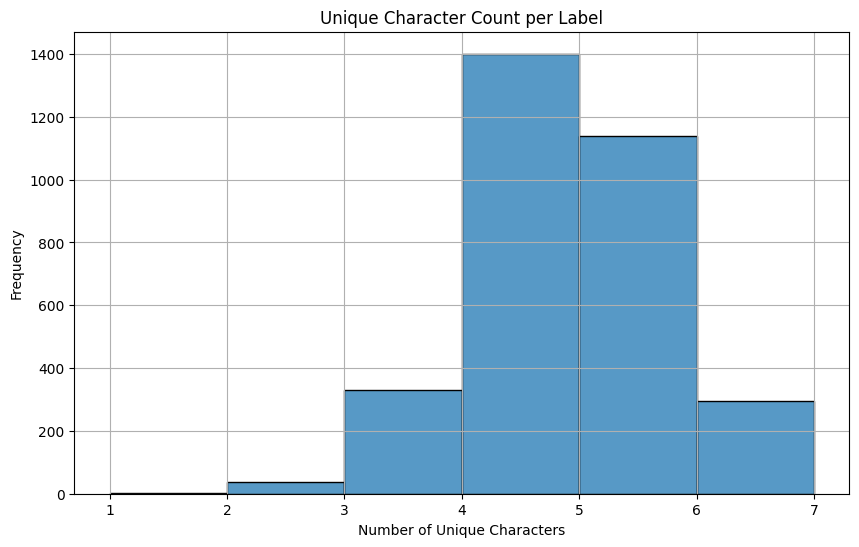

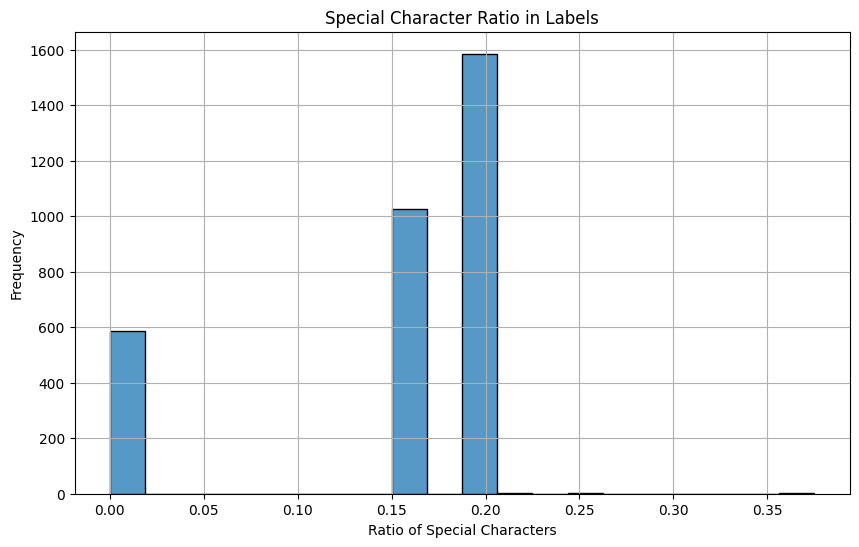

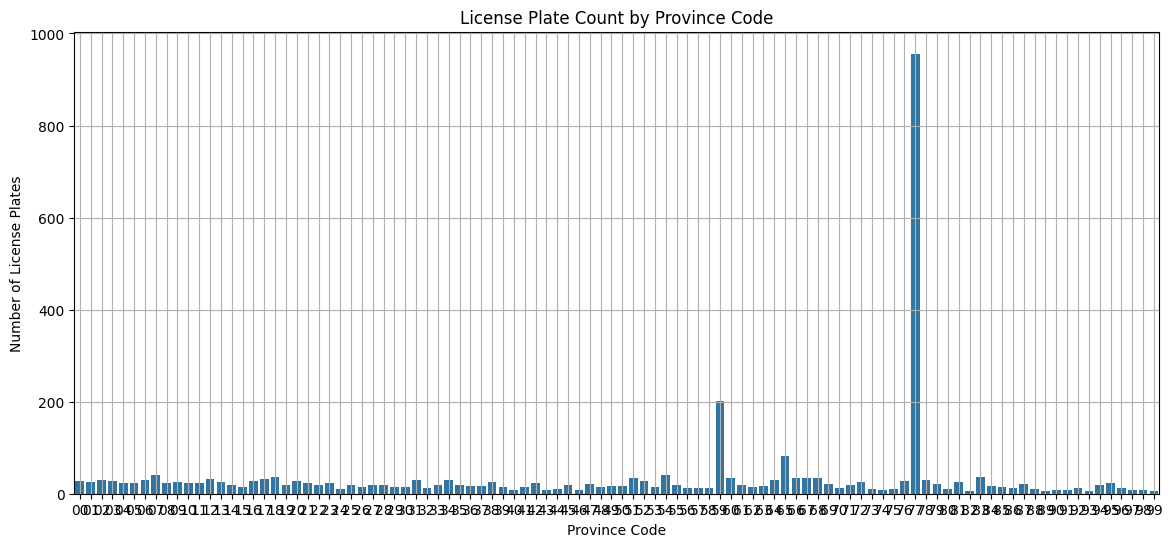

KeyboardInterrupt: 

In [ ]:
gt_file_path = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/rec_gt_train_new.txt'
image_folder = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/train_set'

df_ocr, char_df, resolution_df, duplicate_labels = run_advanced_eda(gt_file_path, image_folder)


In [ ]:
def eda_summary(df, char_df, missing_imgs, empty_labels):
    print("\n=========== DATASET SUMMARY REPORT ===========")

    # General dataset info
    total_samples = len(df)
    unique_labels = df['label'].nunique()

    print(f"Total samples: {total_samples}")
    print(f"Unique labels: {unique_labels}")
    print(f"Missing images: {len(missing_imgs)}")
    print(f"Empty labels: {len(empty_labels)}")

    # Label length stats
    length_desc = df['label'].apply(len).describe()
    print("\nLabel length statistics:")
    print(length_desc)

    # Most frequent characters
    top_chars = char_df.sort_values(by='Frequency', ascending=False).head(5)
    print("\nTop 5 most frequent characters:")
    for idx, row in top_chars.iterrows():
        print(f"  Character: '{row['Character']}' | Frequency: {row['Frequency']}")

    # Special characters with high frequencies
    print("\nSpecial characters with high frequencies:")
    special_char_df = char_df[~char_df['Character'].str.match(r'^[A-Za-z0-9]$')]
    if not special_char_df.empty:
        print(special_char_df.sort_values(by='Frequency', ascending=False))
    else:
        print("No special characters found.")

    # Most frequent province codes
    df['province_code'] = df['label'].str.extract(r'^(\d{2})')
    province_counts = df['province_code'].value_counts().head(5)
    print("\nTop 5 province codes by label count:")
    for province, count in province_counts.items():
        print(f"  Province Code: {province} | Count: {count}")

    print("==============================================")

    def run_full_eda(gt_file_path, image_folder, sample_image_count=5):
      print("Starting dataset analysis...")

      # Load label data
      df = load_labels(gt_file_path)

      # Basic dataset overview
      data_overview(df)

      # Label length distribution
      label_length_distribution(df)

      # Character frequency
      char_df = char_frequency(df)

      # Show sample images
      show_sample_images(df, image_folder, sample_image_count)

      # Check data issues
      missing_imgs, empty_labels = check_data_issues(df, image_folder)

      # Validate labels
      invalid_labels = validate_labels(df)

      # Print labels with special characters
      print_labels_by_special_char(df)

      # Generate summary report
      eda_summary(df, char_df, missing_imgs, empty_labels)

      print("EDA process completed.")

      return df, char_df



Starting dataset analysis...
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  3204 non-null   object
 1   label     3204 non-null   object
dtypes: object(2)
memory usage: 50.2+ KB
None

Sample Records:
                   img_path   label
2663   crop_plate_407_0.jpg  239.97
1532   crop_plate_964_0.jpg  518.55
2536     HR389_images_0.jpg   65-P1
803    crop_plate_930_0.jpg   77-L1
625   crop_plate_1056_0.jpg  122.39

Number of Unique Labels: 1903
Total Samples: 3204


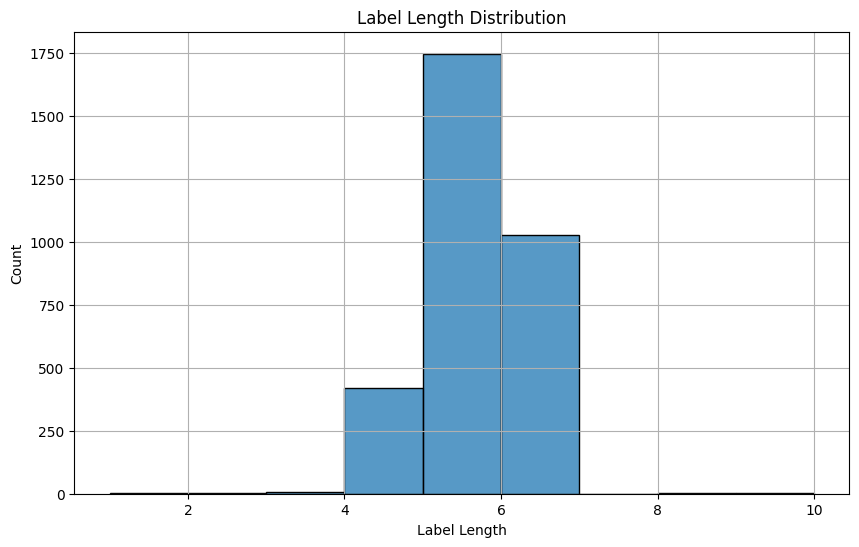

Characters found in the dataset:
  Special character: '-'  |  Frequency: 1568
  Special character: '.'  |  Frequency: 1038
  Special character: '·'  |  Frequency: 6
  Special character: ':'  |  Frequency: 6
  Special character: '\'  |  Frequency: 2
  Special character: '_'  |  Frequency: 1


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


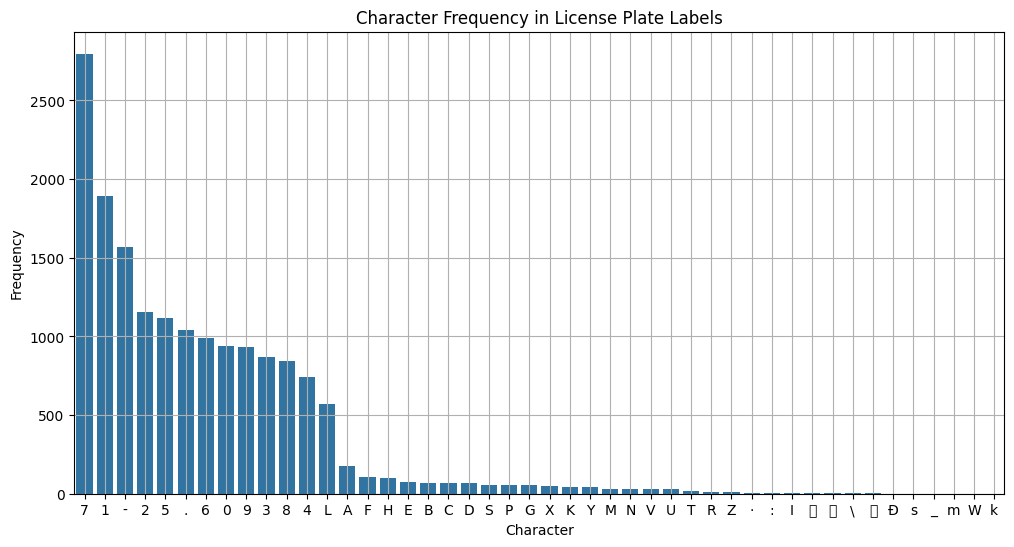

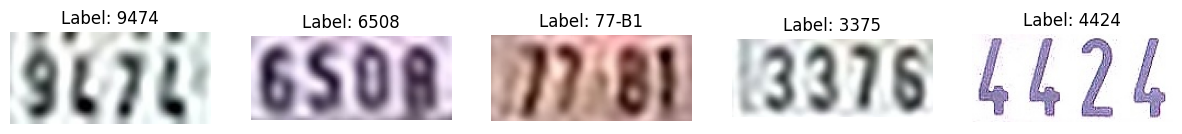

Missing images: 0
Empty labels: 0
Invalid labels count: 3197

First 10 invalid labels:


,label,cleaned_label
0,72-F1,72-F1
1,20741,20741
2,77-L1,77-L1
3,833.35,833.35
4,050.69,050.69
5,77-G1,77-G1
6,77-L1,77-L1
7,056.03,056.03
8,65-X3,65-X3
9,1313,1313


Labels containing special characters:

Special character: '-'  |  Labels count: 1568
['72-F1', '77-L1', '77-G1', '77-L1', '65-X3', '59-L1', '51-Z3', '77-L1', '77-L1', '52-H9']
------------------------------------------------------------
Special character: '.'  |  Labels count: 1038
['833.35', '050.69', '056.03', '540.63', '778.35', '597.53', '656.57', '463.12', '661.56', '040.79']
------------------------------------------------------------
Special character: '·'  |  Labels count: 6
['64·H2', '51·L3', '65·R1', '00·C1', '59·E1', '71·B1']
------------------------------------------------------------
Special character: ':'  |  Labels count: 6
['81:83', '77:B1', '59:F1', '77:D1', '59:N1', '77:L2']
------------------------------------------------------------
Special character: '\'  |  Labels count: 1
['81-F5\\\\1']
------------------------------------------------------------
Special character: '_'  |  Labels count: 1
['81_H1']
------------------------------------------------------------
EDA 

In [ ]:
gt_file_path = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/rec_gt_train_new.txt'
image_folder = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/rec/train_set'

df_ocr, char_df = run_full_eda(gt_file_path, image_folder, sample_image_count=5)


In [1]:
# prompt: data_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates"
# từ folder chưa các ảnh này, bạn hãy copy vào folder mới 200 ảnh random
# rror: Source directory '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates' does not exist.

import os
import random
import shutil

data_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates"
new_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400"  # Thay đổi đường dẫn nếu cần

# Kiểm tra xem thư mục nguồn có tồn tại không
if not os.path.exists(data_dir):
    print(f"Lỗi: Thư mục nguồn '{data_dir}' không tồn tại.")
else:
    # Kiểm tra xem thư mục đích có tồn tại không, nếu không thì tạo mới
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    # Lấy danh sách tất cả các tệp ảnh trong thư mục nguồn
    image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Nếu số lượng ảnh ít hơn 200, copy tất cả
    if len(image_files) < 200:
        for file in image_files:
            shutil.copy2(os.path.join(data_dir, file), new_dir)
        print(f"Đã copy {len(image_files)} ảnh sang thư mục '{new_dir}'")
    else:
        # Chọn ngẫu nhiên 200 ảnh
        random_images = random.sample(image_files, 400)

        # Copy các ảnh đã chọn sang thư mục mới
        for file in random_images:
            shutil.copy2(os.path.join(data_dir, file), new_dir)
        print(f"Đã copy 200 ảnh ngẫu nhiên sang thư mục '{new_dir}'")


Đã copy 200 ảnh ngẫu nhiên sang thư mục '/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400'


In [3]:
import os
import cv2

def scale_images_in_folder(input_folder, scale_factor, output_folder):
    """
    Scale all images in a folder by a given scale factor and save to output folder.

    Args:
        input_folder (str): Path to folder containing images.
        scale_factor (float): Scaling factor (e.g., 0.5 for 50%).
        output_folder (str): Path to folder where resized images will be saved.
    """

    # Tạo thư mục output nếu chưa có
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Duyệt tất cả file trong folder đầu vào
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Đọc ảnh
        image = cv2.imread(input_path)
        if image is None:
            print(f"Warning: Không đọc được file {filename}")
            continue

        # Resize ảnh
        resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LANCZOS4)

        # Đường dẫn lưu ảnh mới
        output_path = os.path.join(output_folder, filename)

        # Ghi ảnh ra file mới
        cv2.imwrite(output_path, resized_image)

        print(f"Scaled {filename} x{scale_factor} --> Saved to {output_path}")

# Ví dụ sử dụng
input_folder = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400"
output_folder = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400_scales"
scale_factor = 5

scale_images_in_folder(input_folder, scale_factor, output_folder)


Scaled crop_plate_CAM025_20250326_1044_Nang_28_2.jpg x5 --> Saved to /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400_scales/crop_plate_CAM025_20250326_1044_Nang_28_2.jpg
Scaled crop_plate_CAM025_20250326_1004_Nang_12_2.jpg x5 --> Saved to /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400_scales/crop_plate_CAM025_20250326_1004_Nang_12_2.jpg
Scaled crop_plate_CAM013_20250326_1618_None_02_2.jpg x5 --> Saved to /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400_scales/crop_plate_CAM013_20250326_1618_None_02_2.jpg
Scaled crop_plate_CAM026_20250326_0933_Nang_40_1.jpg x5 --> Saved to /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400_scales/crop_plate_CAM026_20250326_0933_Nang_40_1.jpg
Scaled crop_plate_CAM021_20250328_1107_Nang_43_0.jpg x5 --> Saved to /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/cropped_plates_400_scales/crop_plate_CAM021_202